In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from chesswinnerprediction.models.naive_model import estimate_prediction_by_elo
from chesswinnerprediction.baseline.utils import estimate_baseline_model, get_x_and_y, get_class_weights, transform_and_scale_df
from chesswinnerprediction.constants import DRAW_STR, PROCESSED_FOLDER_PATH
from chesswinnerprediction.baseline.constants import BASELINE_RANDOM_STATE

In [3]:
data_dir = "lichess_db_standard_rated_2017-05"
data_path = os.path.join(PROCESSED_FOLDER_PATH, data_dir)

In [4]:
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
valid_df = pd.read_csv(os.path.join(data_path, "valid.csv"))

In [5]:
train_df.head()

,Event,WhiteElo,BlackElo,TimeControl,Result,Termination,ECO,White,Black,EloDiff,BaseTime,IncrementTime,ZeroIncrementTime,ResultEncoded,WhiteWin,BlackWin,Draw,times_in_second,GameDuration
0,Rated Classical game,1766,1756,480+0,1-0,Time forfeit,B12,darko9963,SERASKER,10,480,0,1,1,1,0,0,"[480, 480, 477, 477, 474, 476, 472, 472, 470, ...",422
1,Rated Blitz game,1669,1685,300+0,1-0,Normal,C22,Gosha_1982,AndrewVR,-16,300,0,1,1,1,0,0,"[300, 300, 298, 298, 296, 296, 295, 291, 294, ...",370
2,Rated Blitz game,1678,1616,180+0,1-0,Normal,D15,Sl3m,Purfvfet,62,180,0,1,1,1,0,0,"[180, 180, 173, 180, 169, 179, 166, 179, 163, ...",109
3,Rated Bullet game,1905,1843,60+0,1-0,Time forfeit,C41,n0chance,fede4677,62,60,0,1,1,1,0,0,"[60, 60, 59, 59, 58, 58, 57, 58, 56, 57, 55, 5...",112
4,Rated Classical game,2097,2205,900+15,0-1,Normal,B23,Goitia11,bongone,-108,900,15,0,0,0,1,0,"[900, 900, 914, 911, 927, 921, 940, 929, 953, ...",1812


In [6]:
std_scaler = StandardScaler()
train_data = transform_and_scale_df(train_df, std_scaler)
valid_data = transform_and_scale_df(valid_df, std_scaler, fit_scale=False)

## Naive Prediction
Let's implement a naive prediction model. This model will predict that the player with the highest rating will win the game. I will attempt to predict the result both with and without considering draws.


In [7]:
def apply_naive_prediction(count_draws):
    accuracy = estimate_prediction_by_elo(valid_df["WhiteElo"], valid_df["BlackElo"], valid_df["Result"], count_draws=count_draws)
    print(f"\nCount draws: {count_draws}")
    print(f"\tAccuracy: {round(accuracy * 100, 2)}%")

In [8]:
print("\t\tNaive prediction (player with the highest rating wins)")
apply_naive_prediction(count_draws=False)
apply_naive_prediction(count_draws=True)

		Naive prediction (player with the highest rating wins)

Count draws: False
	Accuracy: 60.3%

Count draws: True
	Accuracy: 58.7%


As you can see, neglecting draws results in only a slight decrease in accuracy (-1.5%)

## Class Imbalance
Let's compute class weights for the logistic regression model

In [9]:
no_draws_results = train_df["Result"][train_df["Result"] != DRAW_STR]
scip_draws_class_weights = get_class_weights(no_draws_results, verbose=True)

Class weights:
	1-0: 0.9818507424638327
	0-1: 1.0188328624787057


In [10]:
include_draws_class_weights = get_class_weights(train_df["Result"], verbose=True)

Class weights:
	1-0: 0.6718789964523187
	0-1: 0.6971858059373535
	1/2-1/2: 12.936795431862432


## Logistic Regression Model
Let's implement a logistic regression model to predict the outcome of the game. 

I will try to predict the result both with and without considering draws.


In [11]:
def apply_logistic_regression(predict_draws, train, valid, penalty="l1", solver="saga", max_iter=300, tol=1e-3):
    X_train, y_train = get_x_and_y(train, predict_draws=predict_draws)
    X_valid, y_valid = get_x_and_y(valid, predict_draws=predict_draws)
        
    model = LogisticRegression(
        random_state=BASELINE_RANDOM_STATE,
        class_weight=get_class_weights(y_train), 
        tol=tol,
        max_iter=max_iter, 
        penalty=penalty, 
        solver=solver
    )
    model.fit(X_train, y_train)
    
    feature_importance = np.abs(model.coef_[0])
    estimate_baseline_model(model, feature_importance, X_train, y_train, X_valid, y_valid)

#### Predicting Without Draws Using L2 Penalties


log loss on test data: 0.6540542077178005

						 Train Report 									 Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.59      0.60      0.60    378036              0.60      0.60      0.60     45521
         1-0       0.61      0.60      0.61    392275              0.61      0.61      0.61     47220
    accuracy                           0.60    770311                                  0.60     92741
   macro avg       0.60      0.60      0.60    770311              0.60      0.60      0.60     92741
weighted avg       0.60      0.60      0.60    770311              0.60      0.60      0.60     92741
       


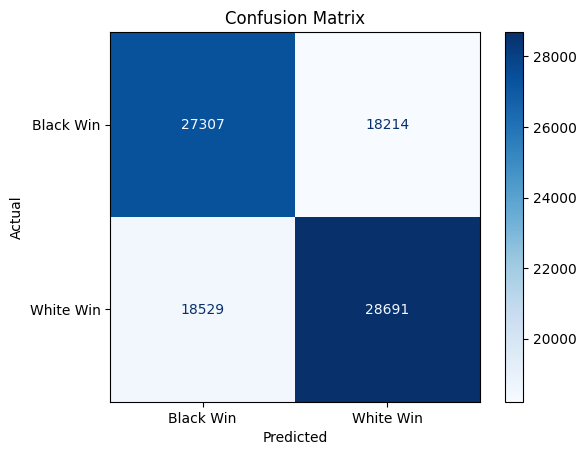

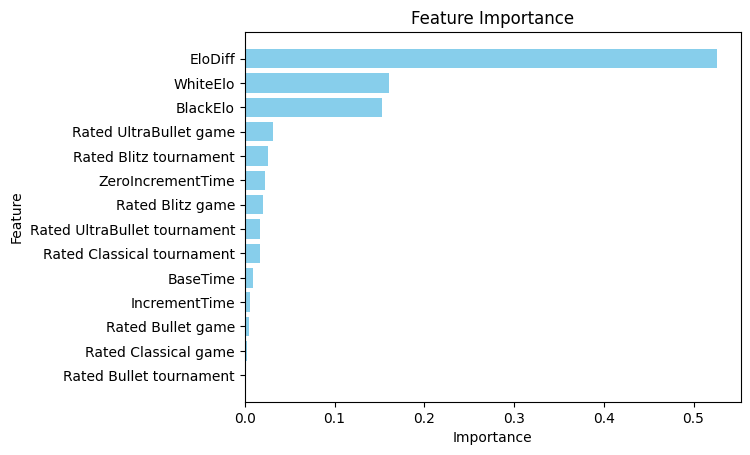

In [12]:
apply_logistic_regression(predict_draws=False, train=train_data, valid=valid_data, penalty="l2")

#### Predicting Without Draws Using L2 Penalties

log loss on test data: 0.6540354751038064

						 Train Report 									 Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.59      0.60      0.60    378036              0.60      0.60      0.60     45521
         1-0       0.61      0.61      0.61    392275              0.61      0.61      0.61     47220
    accuracy                           0.60    770311                                  0.60     92741
   macro avg       0.60      0.60      0.60    770311              0.60      0.60      0.60     92741
weighted avg       0.60      0.60      0.60    770311              0.60      0.60      0.60     92741
       


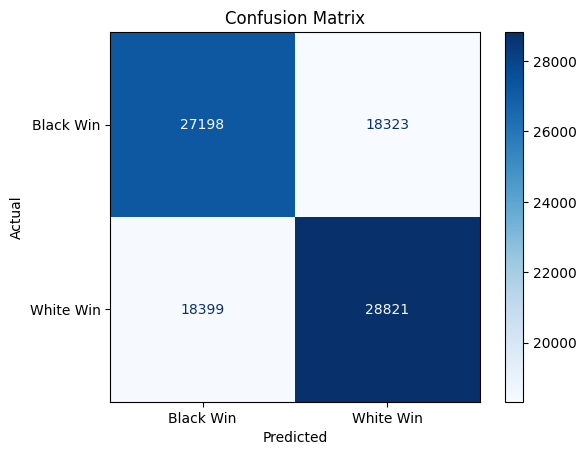

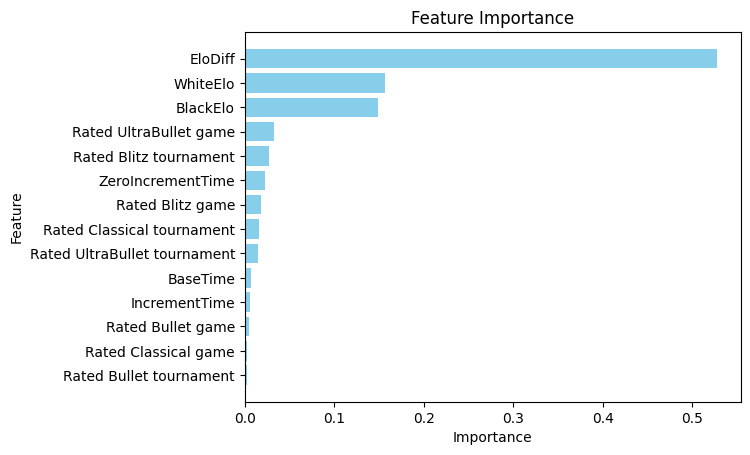

In [13]:
apply_logistic_regression(predict_draws=False, train=train_data, valid=valid_data, penalty="l1", tol=5e-3)

Accuracy is close to naive prediction (around 60%). The most important feature is the difference in ELO, which is especially evident when using L1 penalty.


#### Predicting With Draws Using L2 Penalties

log loss on test data: 1.0368471077991548

						 Train Report 									 Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.59      0.42      0.49    378036              0.59      0.42      0.49     45521
         1-0       0.61      0.41      0.49    392275              0.61      0.41      0.49     47220
     1/2-1/2       0.04      0.57      0.08     20373              0.05      0.57      0.08      2522
    accuracy                           0.42    790684                                  0.42     95263
   macro avg       0.42      0.47      0.35    790684              0.42      0.47      0.35     95263
weighted avg       0.59      0.42      0.48    790684              0.59      0.42      0.48     95263
       


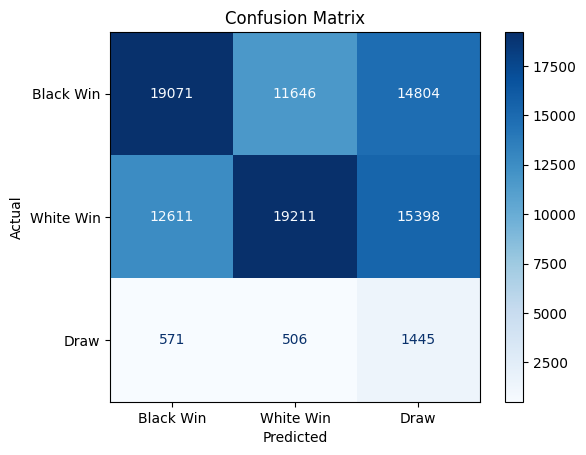

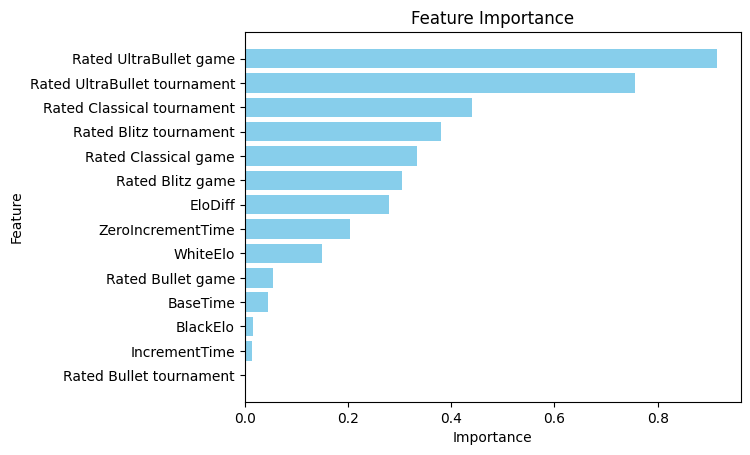

In [14]:
apply_logistic_regression(predict_draws=True, train=train_data, valid=valid_data, penalty="l2")

Of course, predicting draws has negatively impacted the overall picture: both recall and F1 score have dropped significantly. Draws have poor precision and F1 score, but quite decent recall.

It's also interesting to note, that the feature importance chart looks completely different here.


log loss on test data: 1.0368461815536991

						 Train Report 									 Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.59      0.42      0.49    378036              0.59      0.42      0.49     45521
         1-0       0.61      0.41      0.49    392275              0.61      0.41      0.49     47220
     1/2-1/2       0.04      0.57      0.08     20373              0.05      0.57      0.08      2522
    accuracy                           0.42    790684                                  0.42     95263
   macro avg       0.42      0.47      0.35    790684              0.42      0.47      0.35     95263
weighted avg       0.59      0.42      0.48    790684              0.59      0.42      0.48     95263
       


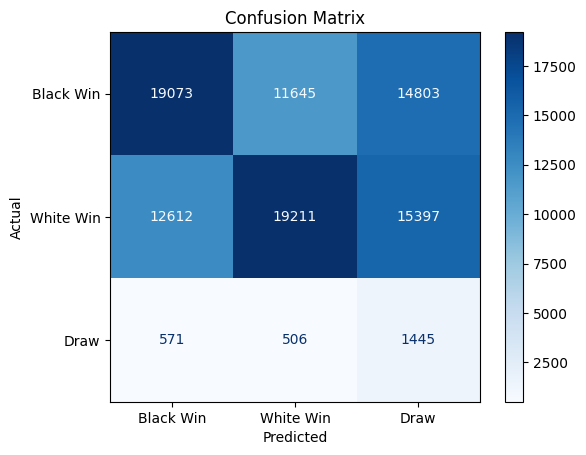

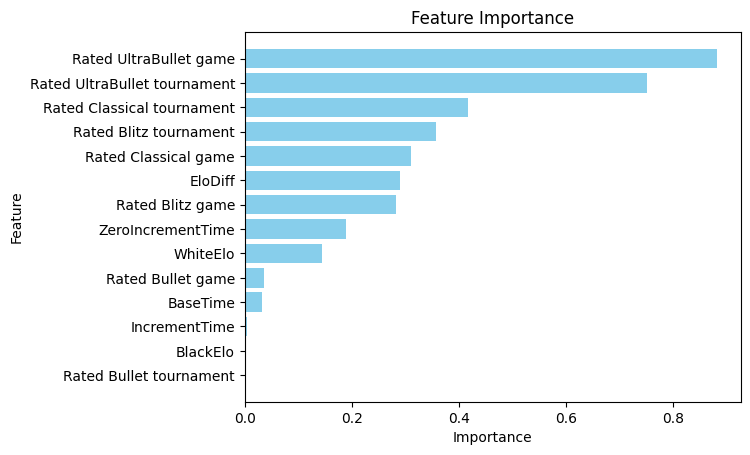

In [15]:
apply_logistic_regression(predict_draws=True, train=train_data, valid=valid_data, penalty="l1", tol=5e-3)

The L1 penalty moved EloDiff to the top position again. Interestingly, this did not affect the model's results. Both models have identical precision, recall, and F1 scores.
